In [1]:
from importlib import reload
from time import time 

import numpy as np
import scipy as sc
import pandas as pd
import torch

import utils
import rna
import models

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
plt.rcParams["font.size"] = 14

import seaborn as sns
sns.set_style('whitegrid')

Build menu of design algorithm configuration names.

In [4]:
adalead_thresholds = [0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)

design_names = ['vae-ridge']  # VAE trained on training sequences as a "baseline" configuration
for model_name in ['ridge', 'fc', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
    
    # CbAS
    for q in cbas_dbas_quantiles:
        q = round(q, 2)
        design_names.append(f'cbas-{model_name}-{q}')
        
    # DbAS
    if model_name != 'ridge':
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')
    else:
        design_names.append(f'dbas-ridge-0.1')
        design_names.append(f'dbas-ridge-0.2')

print('Menu contains {} configurations.'.format(len(design_names)))

Menu contains 78 configurations.


Run methods that use held-out labeled data (ours and CalibratedForecasts).

In [102]:
reload(utils)
reload(dre)
reload(rna)

pp_csv_fname = None
cf_csv_fname = None
device = torch.device('cuda')
design_pkl_fname = 'rna-results/rna-designs-5kmodel.pkl'

# TODO: try cbas-ridge-0.\d
mdre_group_regex_strs = [
    'adalead-ridge-0.\d',
    'adalead-fc-0.\d',
    'adalead-cnn-0.\d',
    'biswas-ridge-0.\d',
    'biswas-fc-0.\d',
    'biswas-cnn-0.\d',
    'dbas-fc-0.\d',
    'dbas-cnn-0.\d',
    'pex-ridge',
    'pex-fc',
    'pex-cnn',
    'dbas-ridge-0.1',
    'dbas-ridge-0.2',
    'cbas-ridge-0.1',
    'cbas-ridge-0.2',
    'cbas-ridge-0.3',
    'cbas-ridge-0.4',
    'cbas-ridge-0.5',
    'cbas-ridge-0.6',
    'cbas-ridge-0.7',
    'cbas-ridge-0.8',
    'cbas-ridge-0.9',
    'cbas-fc-0.\d',
    'cbas-cnn-0.\d',
    'vae-ridge'
]

pp_df, cf_df = rna.select_for_mean_with_labeled_data(
    design_names,
    design_pkl_fname,
    desired_values,
    mdre_group_regex_strs,
    n_trial=8,
    n_design_forecasts=1000,
    quad_limit=100,
    use_quadratic_layer_mdre=True,
    pp_csv_fname=pp_csv_fname,
    cf_csv_fname=cf_csv_fname,
    device=device,
)

done w/ vae-ridge (0.284, true 0.285), lower_int_limit 0.102, upper_int_limit 0.442, t1_err 0.0048, 1 s
done w/ adalead-ridge-0.2 (0.399, true 0.366), lower_int_limit 0.304, upper_int_limit 0.574, t1_err 0.0019, 3 s
done w/ adalead-ridge-0.15 (0.408, true 0.376), lower_int_limit 0.315, upper_int_limit 0.596, t1_err 0.0019, 5 s
done w/ adalead-ridge-0.1 (0.418, true 0.384), lower_int_limit 0.323, upper_int_limit 0.615, t1_err 0.0020, 7 s
done w/ adalead-ridge-0.05 (0.432, true 0.405), lower_int_limit 0.340, upper_int_limit 0.651, t1_err 0.0021, 9 s
done w/ adalead-ridge-0.01 (0.429, true 0.408), lower_int_limit 0.338, upper_int_limit 0.619, t1_err 0.0019, 11 s
done w/ biswas-ridge-0.02 (0.343, true 0.326), lower_int_limit 0.180, upper_int_limit 0.557, t1_err 0.0053, 13 s
done w/ biswas-ridge-0.015 (0.354, true 0.336), lower_int_limit 0.143, upper_int_limit 0.550, t1_err 0.0056, 14 s
done w/ biswas-ridge-0.01 (0.372, true 0.353), lower_int_limit 0.203, upper_int_limit 0.558, t1_err 0.005

done w/ dbas-cnn-0.7 (0.326, true 0.333), lower_int_limit 0.000, upper_int_limit 0.719, t1_err 0.0021, 128 s
done w/ dbas-cnn-0.8 (0.321, true 0.329), lower_int_limit 0.000, upper_int_limit 0.687, t1_err 0.0019, 130 s
done w/ dbas-cnn-0.9 (0.318, true 0.324), lower_int_limit 0.000, upper_int_limit 0.704, t1_err 0.0019, 132 s
Done running 1 / 8 trials (132 s).
done w/ vae-ridge (0.284, true 0.285), lower_int_limit 0.124, upper_int_limit 0.442, t1_err 0.0024, 135 s
done w/ adalead-ridge-0.2 (0.399, true 0.366), lower_int_limit 0.304, upper_int_limit 0.609, t1_err 0.0022, 137 s
done w/ adalead-ridge-0.15 (0.410, true 0.376), lower_int_limit 0.315, upper_int_limit 0.597, t1_err 0.0020, 139 s
done w/ adalead-ridge-0.1 (0.418, true 0.384), lower_int_limit 0.323, upper_int_limit 0.618, t1_err 0.0021, 141 s
done w/ adalead-ridge-0.05 (0.432, true 0.405), lower_int_limit 0.340, upper_int_limit 0.657, t1_err 0.0022, 143 s
done w/ adalead-ridge-0.01 (0.428, true 0.408), lower_int_limit 0.338, upp

done w/ dbas-cnn-0.3 (0.316, true 0.322), lower_int_limit 0.000, upper_int_limit 0.672, t1_err 0.0020, 251 s
done w/ dbas-cnn-0.4 (0.314, true 0.319), lower_int_limit 0.000, upper_int_limit 0.702, t1_err 0.0021, 253 s
done w/ dbas-cnn-0.5 (0.331, true 0.341), lower_int_limit 0.000, upper_int_limit 0.703, t1_err 0.0043, 254 s
done w/ dbas-cnn-0.6 (0.307, true 0.312), lower_int_limit 0.000, upper_int_limit 0.682, t1_err 0.0019, 256 s
done w/ dbas-cnn-0.7 (0.326, true 0.333), lower_int_limit 0.000, upper_int_limit 0.724, t1_err 0.0039, 257 s
done w/ dbas-cnn-0.8 (0.323, true 0.329), lower_int_limit 0.000, upper_int_limit 0.680, t1_err 0.0021, 260 s
done w/ dbas-cnn-0.9 (0.319, true 0.324), lower_int_limit 0.000, upper_int_limit 0.702, t1_err 0.0020, 262 s
Done running 2 / 8 trials (262 s).
done w/ vae-ridge (0.285, true 0.285), lower_int_limit 0.107, upper_int_limit 0.446, t1_err 0.0025, 264 s
done w/ adalead-ridge-0.2 (0.399, true 0.366), lower_int_limit 0.304, upper_int_limit 0.591, t1_

done w/ cbas-cnn-0.8 (0.289, true 0.291), lower_int_limit 0.000, upper_int_limit 0.657, t1_err 0.0021, 374 s
done w/ cbas-cnn-0.9 (0.289, true 0.291), lower_int_limit 0.000, upper_int_limit 0.646, t1_err 0.0022, 376 s
done w/ dbas-cnn-0.1 (0.309, true 0.313), lower_int_limit 0.000, upper_int_limit 0.701, t1_err 0.0018, 378 s
done w/ dbas-cnn-0.2 (0.310, true 0.317), lower_int_limit 0.000, upper_int_limit 0.683, t1_err 0.0021, 380 s
done w/ dbas-cnn-0.3 (0.316, true 0.322), lower_int_limit 0.000, upper_int_limit 0.663, t1_err 0.0022, 382 s
done w/ dbas-cnn-0.4 (0.313, true 0.319), lower_int_limit 0.000, upper_int_limit 0.712, t1_err 0.0039, 383 s
done w/ dbas-cnn-0.5 (0.331, true 0.341), lower_int_limit 0.000, upper_int_limit 0.693, t1_err 0.0022, 385 s
done w/ dbas-cnn-0.6 (0.309, true 0.312), lower_int_limit 0.000, upper_int_limit 0.688, t1_err 0.0019, 387 s
done w/ dbas-cnn-0.7 (0.325, true 0.333), lower_int_limit 0.000, upper_int_limit 0.730, t1_err 0.0041, 388 s
done w/ dbas-cnn-0.

done w/ cbas-cnn-0.4 (0.289, true 0.290), lower_int_limit 0.000, upper_int_limit 0.672, t1_err 0.0020, 500 s
done w/ cbas-cnn-0.5 (0.289, true 0.289), lower_int_limit 0.000, upper_int_limit 0.667, t1_err 0.0020, 502 s
done w/ cbas-cnn-0.6 (0.290, true 0.290), lower_int_limit 0.000, upper_int_limit 0.668, t1_err 0.0019, 504 s
done w/ cbas-cnn-0.7 (0.289, true 0.290), lower_int_limit 0.000, upper_int_limit 0.646, t1_err 0.0021, 506 s
done w/ cbas-cnn-0.8 (0.291, true 0.291), lower_int_limit 0.000, upper_int_limit 0.638, t1_err 0.0020, 508 s
done w/ cbas-cnn-0.9 (0.291, true 0.291), lower_int_limit 0.000, upper_int_limit 0.652, t1_err 0.0023, 510 s
done w/ dbas-cnn-0.1 (0.311, true 0.313), lower_int_limit 0.000, upper_int_limit 0.691, t1_err 0.0018, 512 s
done w/ dbas-cnn-0.2 (0.311, true 0.317), lower_int_limit 0.000, upper_int_limit 0.699, t1_err 0.0019, 514 s
done w/ dbas-cnn-0.3 (0.316, true 0.322), lower_int_limit 0.000, upper_int_limit 0.671, t1_err 0.0042, 515 s
done w/ dbas-cnn-0.

done w/ pex-cnn (0.326, true 0.344), lower_int_limit 0.000, upper_int_limit 0.667, t1_err 0.0021, 623 s
done w/ cbas-cnn-0.1 (0.288, true 0.288), lower_int_limit 0.000, upper_int_limit 0.649, t1_err 0.0019, 625 s
done w/ cbas-cnn-0.2 (0.289, true 0.290), lower_int_limit 0.000, upper_int_limit 0.642, t1_err 0.0020, 627 s
done w/ cbas-cnn-0.3 (0.290, true 0.290), lower_int_limit 0.000, upper_int_limit 0.655, t1_err 0.0019, 629 s
done w/ cbas-cnn-0.4 (0.289, true 0.290), lower_int_limit 0.000, upper_int_limit 0.656, t1_err 0.0018, 631 s
done w/ cbas-cnn-0.5 (0.289, true 0.289), lower_int_limit 0.000, upper_int_limit 0.671, t1_err 0.0019, 633 s
done w/ cbas-cnn-0.6 (0.289, true 0.290), lower_int_limit 0.000, upper_int_limit 0.644, t1_err 0.0019, 635 s
done w/ cbas-cnn-0.7 (0.289, true 0.290), lower_int_limit 0.000, upper_int_limit 0.644, t1_err 0.0019, 637 s
done w/ cbas-cnn-0.8 (0.290, true 0.291), lower_int_limit 0.000, upper_int_limit 0.639, t1_err 0.0020, 639 s
done w/ cbas-cnn-0.9 (0.

done w/ biswas-cnn-0.015 (0.319, true 0.326), lower_int_limit 0.000, upper_int_limit 0.692, t1_err 0.0020, 750 s
done w/ biswas-cnn-0.01 (0.332, true 0.342), lower_int_limit 0.000, upper_int_limit 0.686, t1_err 0.0020, 752 s
done w/ biswas-cnn-0.005 (0.353, true 0.367), lower_int_limit 0.000, upper_int_limit 0.719, t1_err 0.0017, 754 s
done w/ pex-cnn (0.324, true 0.344), lower_int_limit 0.000, upper_int_limit 0.685, t1_err 0.0021, 756 s
done w/ cbas-cnn-0.1 (0.287, true 0.288), lower_int_limit 0.000, upper_int_limit 0.635, t1_err 0.0019, 758 s
done w/ cbas-cnn-0.2 (0.290, true 0.290), lower_int_limit 0.000, upper_int_limit 0.647, t1_err 0.0020, 760 s
done w/ cbas-cnn-0.3 (0.289, true 0.290), lower_int_limit 0.000, upper_int_limit 0.646, t1_err 0.0021, 762 s
done w/ cbas-cnn-0.4 (0.289, true 0.290), lower_int_limit 0.000, upper_int_limit 0.678, t1_err 0.0018, 764 s
done w/ cbas-cnn-0.5 (0.287, true 0.289), lower_int_limit 0.000, upper_int_limit 0.651, t1_err 0.0019, 766 s
done w/ cbas-

done w/ adalead-cnn-0.05 (0.381, true 0.410), lower_int_limit 0.026, upper_int_limit 0.742, t1_err 0.0017, 876 s
done w/ adalead-cnn-0.01 (0.383, true 0.416), lower_int_limit 0.005, upper_int_limit 0.763, t1_err 0.0016, 878 s
done w/ biswas-cnn-0.02 (0.310, true 0.317), lower_int_limit 0.000, upper_int_limit 0.673, t1_err 0.0021, 880 s
done w/ biswas-cnn-0.015 (0.318, true 0.326), lower_int_limit 0.000, upper_int_limit 0.671, t1_err 0.0020, 882 s
done w/ biswas-cnn-0.01 (0.332, true 0.342), lower_int_limit 0.000, upper_int_limit 0.688, t1_err 0.0018, 884 s
done w/ biswas-cnn-0.005 (0.354, true 0.367), lower_int_limit 0.010, upper_int_limit 0.703, t1_err 0.0016, 886 s
done w/ pex-cnn (0.324, true 0.344), lower_int_limit 0.000, upper_int_limit 0.694, t1_err 0.0041, 887 s
done w/ cbas-cnn-0.1 (0.286, true 0.288), lower_int_limit 0.000, upper_int_limit 0.644, t1_err 0.0021, 890 s
done w/ cbas-cnn-0.2 (0.289, true 0.290), lower_int_limit 0.000, upper_int_limit 0.679, t1_err 0.0020, 892 s
do

done w/ adalead-cnn-0.2 (0.354, true 0.372), lower_int_limit 0.000, upper_int_limit 0.721, t1_err 0.0033, 998 s
done w/ adalead-cnn-0.15 (0.360, true 0.382), lower_int_limit 0.007, upper_int_limit 0.725, t1_err 0.0017, 1000 s
done w/ adalead-cnn-0.1 (0.367, true 0.389), lower_int_limit 0.016, upper_int_limit 0.747, t1_err 0.0037, 1001 s
done w/ adalead-cnn-0.05 (0.381, true 0.410), lower_int_limit 0.032, upper_int_limit 0.746, t1_err 0.0015, 1004 s
done w/ adalead-cnn-0.01 (0.383, true 0.416), lower_int_limit 0.034, upper_int_limit 0.749, t1_err 0.0016, 1006 s
done w/ biswas-cnn-0.02 (0.310, true 0.317), lower_int_limit 0.000, upper_int_limit 0.682, t1_err 0.0021, 1008 s
done w/ biswas-cnn-0.015 (0.319, true 0.326), lower_int_limit 0.000, upper_int_limit 0.681, t1_err 0.0020, 1010 s
done w/ biswas-cnn-0.01 (0.334, true 0.342), lower_int_limit 0.000, upper_int_limit 0.689, t1_err 0.0019, 1012 s
done w/ biswas-cnn-0.005 (0.354, true 0.367), lower_int_limit 0.000, upper_int_limit 0.715, t

In [83]:
import pickle

In [84]:
design_pkl_fname = 'rna-results/rna-designs-5kmodel.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata5k = pickle.load(f)
    
for name, (seq, y_n, pred_n) in name2designdata5k.items():
    mu_n, sigma_n = name2designmusigma[name]
    assert(np.max(np.abs(pred_n - mu_n)) < 1e-16)
    name2designdata5k[name] = (seq, y_n, pred_n, sigma_n)

In [85]:
with open(design_pkl_fname, 'wb') as f:
    pickle.dump(name2designdata5k, f)

In [56]:
df = (pd.Series(name2truemean)
        .rename_axis("configuration")          # old index name → column
        .reset_index(name="mean_design_label"))
df.to_csv("rna-results/true-mean-labels-5k.csv", index=False)

In [104]:
cferr_v, cfsel_v, cfworst_v = rna.process_forecasts_for_plotting(
    cf_df,
    desired_values,
    design_names,
    'rna-results/true-mean-labels-5k.csv',
    n_trial=8,
    method_name='cf'
)

In [67]:
reload(rna)

n_pp_trial = 100
pperr_v, ppsel_v, ppworst_v = rna.process_pvalues_for_plotting(
    pp_df,
    desired_values,
    design_names,
    'rna-results/true-mean-labels-5k.csv',
    n_trial=n_pp_trial,
    method_name='pp'
)

Processing pp results with 78 configurations, 84 desired values in [0.25, 0.50], 100 trials, and alpha = 0.1
Done processing (15 s)


Or, load pre-computed results from our method and CalibratedForecasts for plotting. Plots made with these results should be similar to plots made with results from the above cell, but will vary due to randomness in the held-out labeled data drawn in each trial.

Run methods that do not require held-out labeled data (prediction-only and GMMForecasts).

In [5]:
reload(rna)

n_trial = 10
# files containing 50k designed sequences, their predictions, and true labels,
# for all configurations on the menu
design_pkl_fnames = [f'rna-results/rna-designs-10kmodel-{i}.pkl' for i in range(n_trial)]
desired_values = np.arange(0.25, 0.501, 0.003)      # desired mean design label (tau in success criterion)
po_csv_fname = 'rna-results/demo-po-results.csv'    # CSV to store prediction-only (PO) results
gmm_csv_fname = 'rna-results/demo-gmm-results.csv'  # CSV to store GMMForecasts results

po_df, gmm_df, name2truemeans = rna.select_for_mean_without_labeled_data(
    design_names,
    design_pkl_fnames,
    desired_values,
    po_csv_fname=po_csv_fname,
    gmm_csv_fname=gmm_csv_fname,
)

Done with trial 1 / 10 (139 s).
Done with trial 2 / 10 (277 s).
Done with trial 3 / 10 (415 s).
Done with trial 4 / 10 (554 s).
Done with trial 5 / 10 (692 s).
Done with trial 6 / 10 (830 s).
Done with trial 7 / 10 (968 s).
Done with trial 8 / 10 (1106 s).
Done with trial 9 / 10 (1244 s).
Done with trial 10 / 10 (1382 s).
Saved to rna-results/demo-po-results.csv, rna-results/demo-gmm-results.csv, and rna-results/demo-po-results-truemeans.csv (1382 s).

High-ish variance estimates of true mean labels for:
  cbas-ridge-0.6: 0.3157 0.3194 0.3226 0.3169 0.3172 0.3134 0.3238 0.3178 0.3201 0.3175 
  cbas-ridge-0.7: 0.3277 0.3323 0.3278 0.3305 0.3242 0.3279 0.3333 0.3266 0.3379 0.3290 
  cbas-ridge-0.8: 0.3523 0.3510 0.3523 0.3572 0.3519 0.3510 0.3535 0.3407 0.3655 0.3539 
  cbas-ridge-0.9: 0.4012 0.4110 0.4138 0.4232 0.4001 0.3990 0.4159 0.3977 0.4168 0.4013 
  dbas-ridge-0.1: 0.3043 0.3444 0.3222 0.3413 0.3128 0.3314 0.3415 0.3313 0.3207 0.3294 
  dbas-ridge-0.2: 0.3682 0.3930 0.3406 0.4089

Or, load pre-computed PO/GMMForecasts results for plotting (should match output of above cell).

In [51]:
# gmm_df = pd.read_csv('rna-results/gmm-results.csv', index_col=0)

Process selection results for plotting.

In [58]:
name2truemean10k = {name: np.mean(truemeans) for name, truemeans in name2truemeans.items()}

In [59]:
df = (pd.Series(name2truemean10k)
        .rename_axis("configuration")          # old index name → column
        .reset_index(name="mean_design_label"))
df.to_csv("rna-results/true-mean-labels-10k.csv", index=False)

In [60]:
reload(rna)

truemeans_fname = 'rna-results/true-mean-labels-10k.csv'

poerr_v, posel_v, poworst_v = rna.process_pvalues_for_plotting(
    po_df,
    desired_values,
    design_names,
    truemeans_fname,
    n_trial=n_trial,
    method_name='po'
)

q2gmmresults = rna.process_gmmforecasts_for_plotting(
    gmm_df,
    desired_values,
    design_names,
    truemeans_fname,
    n_trial=n_trial,
)

Processing po results with 78 configurations, 84 desired values in [0.25, 0.50], 10 trials, and alpha = 0.1
Done processing (1 s)
Processing GMMForecasts (w/ cov. shift) results with 78 configurations, 84 desired values in [0.25, 0.50], and 10 trials
Done processing (1 s)


Recreate Fig. 4 in main paper. There will be variation in the PP/CalibratedForecasts plots (green/blue) due to randomness in the held-out labeled data generated in each trial.

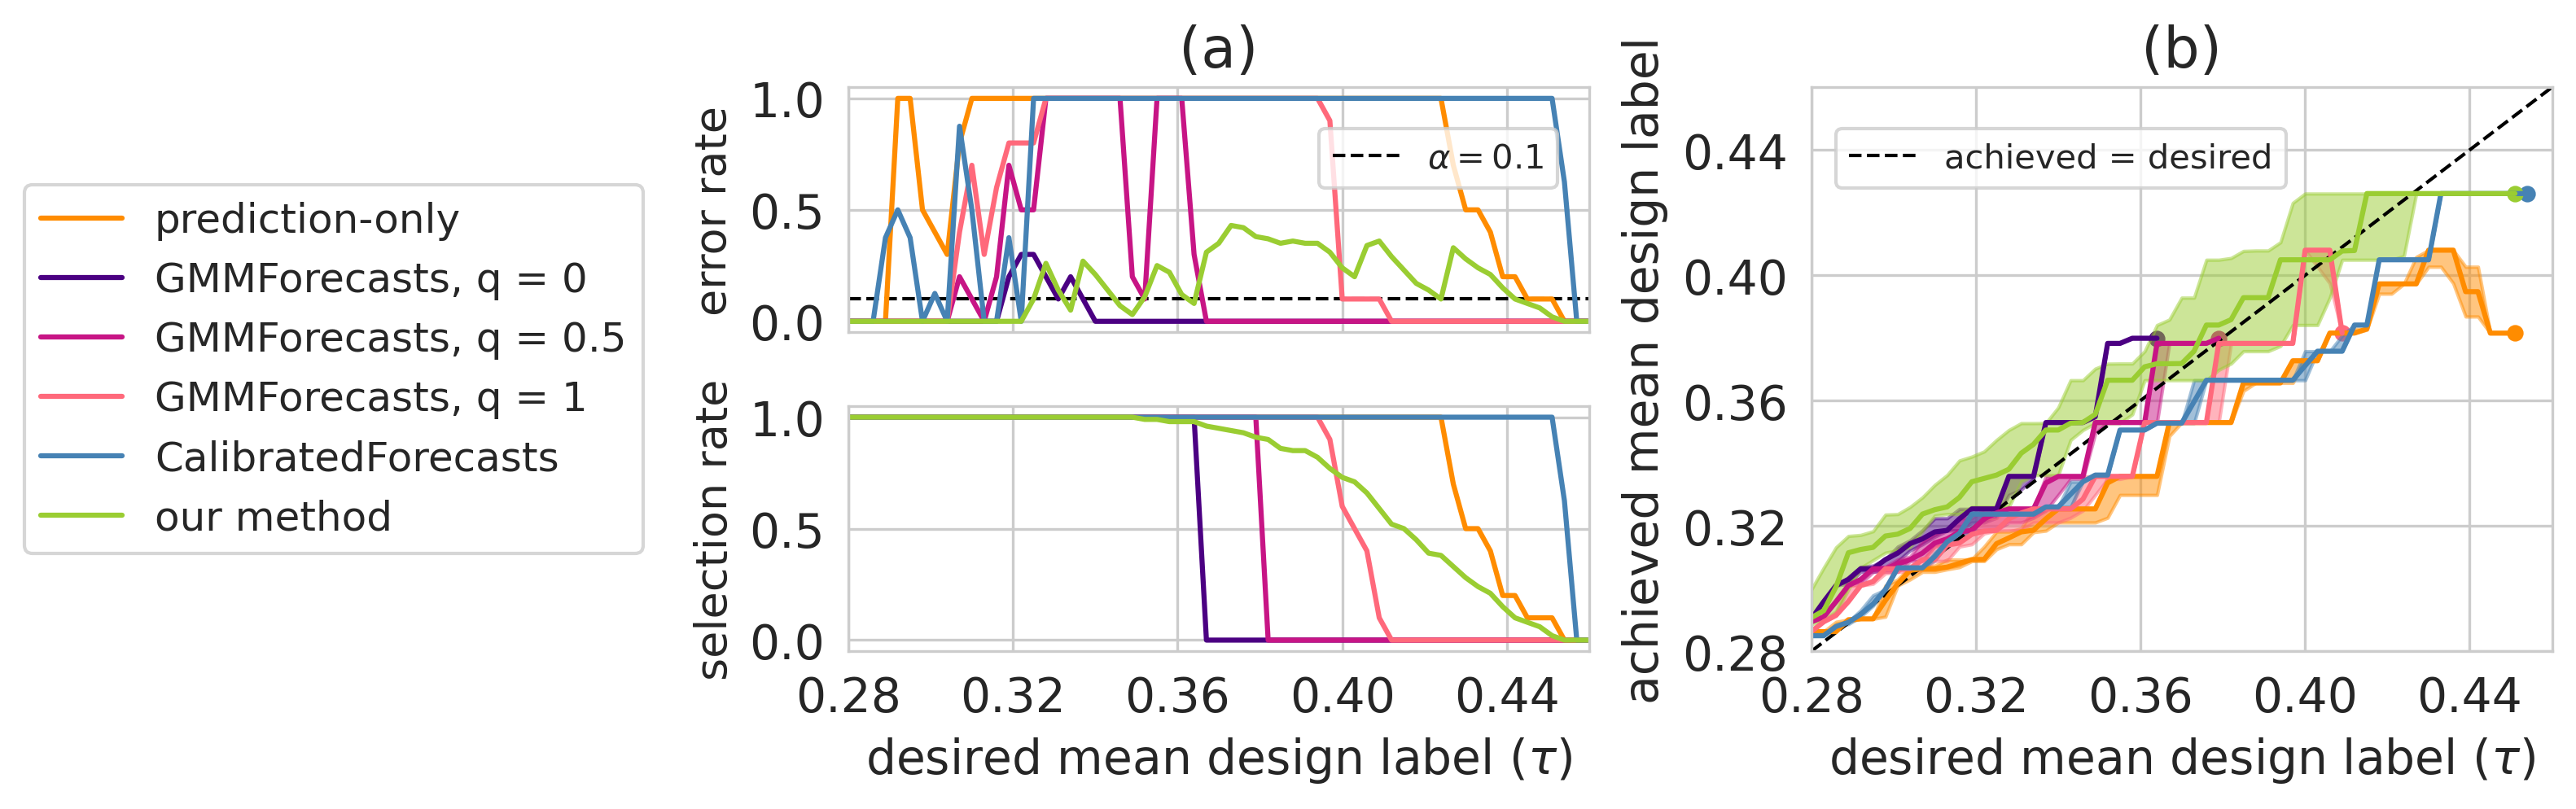

In [107]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(9, 3), dpi=300)

gs = gridspec.GridSpec(1, 2, figure=fig)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0])

ax1 = fig.add_subplot(gs[1])
ax00 = fig.add_subplot(gs0[0])
ax10 = fig.add_subplot(gs0[1])

fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.3)

alpha = 0.1
po_color = 'darkorange'
pp_color = 'yellowgreen'
gmm_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'k'

lw = 1.5
dark_lw = 1
legend_fs = 12
err_lim = [-0.05, 1.05]
err_ticks = [0, 0.5, 1]
tau_lim = [0.28, 0.46]
tau_ticks = np.arange(0.28, 0.46, 0.04)
marker_sz = 15

q_low = 0.2
q_high = 0.8


# ===== subplot (a) =====

# ----- top (error) -----
ax00.axhline(alpha, linestyle='--', color=dark_line_color, alpha=1, linewidth=dark_lw, label=r'$\alpha = {}$'.format(alpha));

ax00.plot(desired_values, poerr_v, c=po_color, linewidth=lw);
for q_idx, q in enumerate(utils.DEFAULT_GMM_QS):
    gmmerr_v, gmmsel_v, _ = q2gmmresults[q]
    ax00.plot(desired_values, gmmerr_v, c=gmm_colors[q_idx], linewidth=lw);
ax00.plot(desired_values, cferr_v, c='steelblue', linewidth=lw);
ax00.plot(desired_values, pperr_v, c=pp_color, linewidth=lw);

ax00.set_yticks(err_ticks)
ax00.set_xlim(tau_lim)
ax00.set_ylim(err_lim)
ax00.set_xticks(tau_ticks)
ax00.set_xticklabels([])
ax00.set_ylabel('error rate', fontsize=13);
ax00.set_title('(a)');

# dummy to get legend labels
ax00.legend(fontsize=10, loc='upper right', bbox_to_anchor=(0.98, 0.9));


# ----- bottom (selection rate) -----

ax10.plot(desired_values, posel_v, '-', c=po_color, linewidth=lw);
for q_idx, q in enumerate(utils.DEFAULT_GMM_QS):
    gmmerr_v, gmmsel_v, _ = q2gmmresults[q]
    ax10.plot(desired_values, gmmsel_v, '-', c=gmm_colors[q_idx], linewidth=lw);
ax10.plot(desired_values, cfsel_v, '-', c='steelblue', linewidth=lw);
ax10.plot(desired_values, ppsel_v, '-', c=pp_color, linewidth=lw);

# dummy so get legend for (b)
ax10.plot([-1, -1], [-1, -1], '--', c=dark_line_color, linewidth=dark_lw, label='achieved = desired')
ax10.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.31, 2.2));

ax10.set_xlim(tau_lim)
ax10.set_ylim(err_lim)
ax10.set_xticks(tau_ticks)
ax10.set_yticks(err_ticks)
ax10.set_ylabel('selection rate', fontsize=13);
ax10.set_xlabel(r'desired mean design label ($\tau$)');



# ===== subplot (b) =====

ax1.plot(tau_lim, tau_lim, '--', c=dark_line_color, alpha=1, linewidth=dark_lw);
median_v = [np.median(worst) if len(worst) else np.nan for worst in poworst_v]
ax1.plot(
    desired_values, median_v,
    c=po_color, label='prediction-only', linewidth=lw,
)

last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(desired_values[last_idx], median_v[last_idx], c=po_color, s=marker_sz, alpha=1)
    
ax1.fill_between(
    desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in poworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in poworst_v],
    color=po_color, alpha=0.5,
)

for q_idx, q in enumerate(utils.DEFAULT_GMM_QS):
    _, _, gmmworst_v = q2gmmresults[q]
    median_v = [np.median(worst) if len(worst) else np.nan for worst in gmmworst_v]
    ax1.plot(
        desired_values, median_v,
        c=gmm_colors[q_idx], label=f'GMMForecasts, q = {q}', linewidth=lw,
    )
    
    last_idx = np.where(np.isnan(median_v))[0][0] - 1
    ax1.scatter(desired_values[last_idx], median_v[last_idx], c=gmm_colors[q_idx], s=marker_sz, alpha=1)
    
    ax1.fill_between(
        desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in gmmworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in gmmworst_v],
        color=gmm_colors[q_idx], alpha=0.5,
    )

median_v = [np.median(worst) if len(worst) else np.nan for worst in cfworst_v]  
ax1.plot(
    desired_values, median_v,
    c='steelblue', label='CalibratedForecasts', linewidth=lw,
)
last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(desired_values[last_idx], median_v[last_idx], c='steelblue', s=marker_sz, alpha=1)
ax1.fill_between(
    desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in cfworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in cfworst_v],
    color='steelblue', alpha=0.5,
)

median_v = [np.median(worst) if len(worst) else np.nan for worst in ppworst_v]  
ax1.plot(
    desired_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='our method', linewidth=lw,
)
last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(desired_values[last_idx], median_v[last_idx], c=pp_color, s=marker_sz, alpha=1)
ax1.fill_between(
    desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)

ax1.set_xlim(tau_lim)
ax1.set_ylim(tau_lim)
ax1.set_xticks(tau_ticks)
ax1.set_yticks(tau_ticks)
# ax1.legend(fontsize=legend_f;s, loc='center left', bbox_to_anchor=(1.05, 0.5))
ax1.legend(fontsize=legend_fs, loc='center right', bbox_to_anchor=(-1.55, 0.5))

ax1.set_title('(b)')
ax1.set_ylabel('achieved mean design label');
ax1.set_xlabel(r'desired mean design label ($\tau$)');
